In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
%matplotlib inline

## CombiPrecip

In [3]:
ds = xr.open_mfdataset("../combiprecip_201805.nc", combine='by_coords')
ds

<xarray.Dataset>
Dimensions:            (chx: 710, chy: 640, dummy: 1, time: 744)
Coordinates:
  * dummy              (dummy) float64 1.0
  * chx                (chx) float64 2.555e+05 2.565e+05 ... 9.635e+05 9.645e+05
  * chy                (chy) float64 -1.595e+05 -1.585e+05 ... 4.795e+05
  * time               (time) datetime64[ns] 2018-05-01T01:00:00 ... 2018-06-01
    lon                (chy, chx) float32 dask.array<chunksize=(640, 710), meta=np.ndarray>
    lat                (chy, chx) float32 dask.array<chunksize=(640, 710), meta=np.ndarray>
Data variables:
    swiss_coordinates  (dummy) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    RR                 (time, chy, chx) float32 dask.array<chunksize=(744, 640, 710), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.6
    institution:               Federal Office of Meteorology and Climatology ...
    References:                
    history:                   Wed Sep 16 07:54:48 2020: ncrcat -O combipreci...
    NCO:                       "4.5.4"
    nco_openmp_thread_number:  1

In [3]:
ds.time.values # hourly measured observations

array(['2018-05-01T01:00:00.000000000', '2018-05-01T02:00:00.000000000',
       '2018-05-01T03:00:00.000000000', '2018-05-01T04:00:00.000000000',
       '2018-05-01T05:00:00.000000000', '2018-05-01T06:00:00.000000000',
       '2018-05-01T07:00:00.000000000', '2018-05-01T08:00:00.000000000',
       '2018-05-01T09:00:00.000000000', '2018-05-01T10:00:00.000000000',
       '2018-05-01T11:00:00.000000000', '2018-05-01T12:00:00.000000000',
       '2018-05-01T13:00:00.000000000', '2018-05-01T14:00:00.000000000',
       '2018-05-01T15:00:00.000000000', '2018-05-01T16:00:00.000000000',
       '2018-05-01T17:00:00.000000000', '2018-05-01T18:00:00.000000000',
       '2018-05-01T19:00:00.000000000', '2018-05-01T20:00:00.000000000',
       '2018-05-01T21:00:00.000000000', '2018-05-01T22:00:00.000000000',
       '2018-05-01T23:00:00.000000000', '2018-05-02T00:00:00.000000000',
       '2018-05-02T01:00:00.000000000', '2018-05-02T02:00:00.000000000',
       '2018-05-02T03:00:00.000000000', '2018-05-02

In [4]:
ds.time.values[0], ds.time.values[-1] # one month, 05/2018

(numpy.datetime64('2018-05-01T01:00:00.000000000'),
 numpy.datetime64('2018-06-01T00:00:00.000000000'))

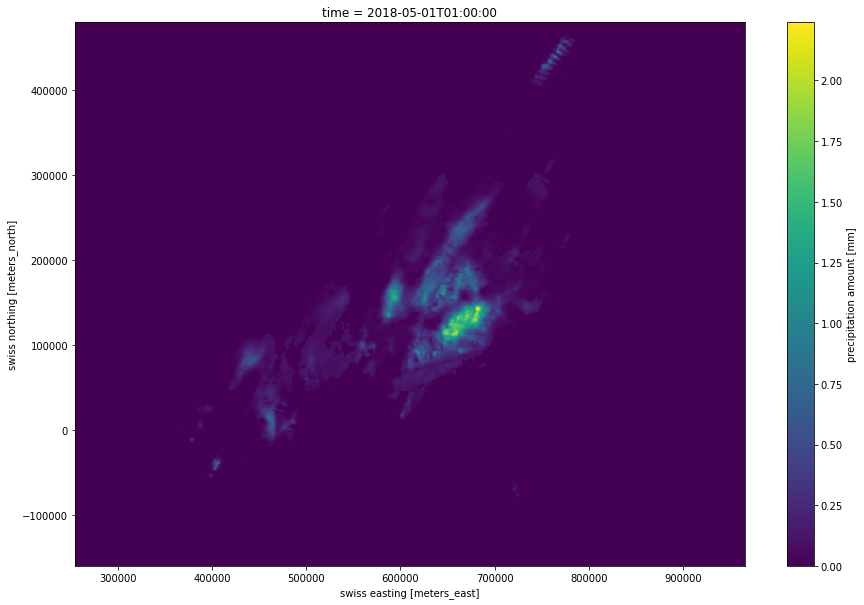

In [5]:
plt.figure(figsize=(15,10))
ds.RR.isel(time=0).plot.pcolormesh("chx", "chy") # observations at time 0, 2018-05-01T00:00:00 -> 2018-05-01T01:00:00

## COSMO-E

In [4]:
cosmo = xr.open_zarr("../cosmoe_prec_201805.zarr")
cosmo

<xarray.Dataset>
Dimensions:   (leadtime: 121, member: 21, reftime: 62, x: 188, y: 127)
Coordinates:
    lat       (y, x) float32 dask.array<chunksize=(127, 188), meta=np.ndarray>
  * leadtime  (leadtime) timedelta64[ns] 00:00:00 01:00:00 ... 5 days 00:00:00
    lon       (y, x) float32 dask.array<chunksize=(127, 188), meta=np.ndarray>
  * member    (member) int32 0 1 2 3 4 5 6 7 8 9 ... 12 13 14 15 16 17 18 19 20
  * reftime   (reftime) datetime64[ns] 2018-05-01 ... 2018-05-31T12:00:00
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 180 181 182 183 184 185 186 187
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 119 120 121 122 123 124 125 126
Data variables:
    PREC      (reftime, leadtime, member, y, x) float32 dask.array<chunksize=(1, 41, 21, 127, 188), meta=np.ndarray>

In [5]:
from pysteps import verification

Pysteps configuration file found at: /Users/alexandrabutoi/opt/anaconda3/envs/Realistic-looking-rainfall-forecasts/lib/python3.8/site-packages/pysteps/pystepsrc



In [18]:
#crps = verification.probscores.CRPS_init()
verification.probscores.CRPS_accum(crps, cosmo.PREC.isel(leadtime=2, reftime=0).values, 
                                   cosmo.PREC.isel(leadtime=2, member=0, reftime=0).values)
verification.probscores.CRPS_compute(crps)

0.018386622012742954

In [7]:
def crps_ensemble(observation, forecasts):
    """
    Computes per image continuous ranked probability score between
    an observation and a probabilistic forecast; code adapted from
    https://github.com/jleinonen/downscaling-rnn-gan/blob/master/dsrnngan/crps.py
    :param observation: observation shaped (height, width)
    :param forecasts: forecast shaped (height, width, members)
    :return: per image CRPS
    """
    fc = forecasts.copy()
    fc.sort(axis=-1)
    obs = observation
    fc_below = fc<obs[...,None]
    crps = np.zeros_like(obs)

    for i in range(fc.shape[-1]):
        below = fc_below[...,i]
        weight = ((i+1)**2 - i**2) / fc.shape[-1]**2
        crps[below] += weight * (obs[below]-fc[...,i][below])

    for i in range(fc.shape[-1]-1,-1,-1):
        above  = ~fc_below[...,i]
        k = fc.shape[-1]-1-i
        weight = ((k+1)**2 - k**2) / fc.shape[-1]**2
        crps[above] += weight * (fc[...,i][above]-obs[above])

    return np.mean(crps)

In [19]:
crps_ensemble(cosmo.PREC.isel(leadtime=2, member=0, reftime=0).values, 
             np.transpose(cosmo.PREC.isel(leadtime=2, reftime=0).values, (1,2,0)))

0.02338687

In [ ]:
np.transpose(cosmo.PREC.isel(leadtime=1, reftime=0).values, (1,2,0))

In [14]:
plt.figure(figsize=(15,10))
cosmo.PREC.isel(leadtime=1, member=0, reftime=0).plot.pcolormesh("x", "y", cmap='viridis', vmin=0, vmax=1)
plt.show()

array([[[ 1.80085897e-01,  2.62250900e-01,  7.13453293e-02, ...,
          8.33034515e-02,  2.63750076e-01,  1.13535881e-01],
        [ 2.18755007e-01,  2.98397064e-01,  1.13252163e-01, ...,
          9.15803909e-02,  3.64530563e-01,  1.49976730e-01],
        [ 2.62215137e-01,  3.29889297e-01,  1.45785332e-01, ...,
          8.19005966e-02,  3.70828629e-01,  2.22229958e-01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.99471951e-01,  2.11376190e-01,  5.04589081e-02, ...,
          8.33148956e-02,  2.79361725e-01,  9.73711014e-02],
        [ 2.35638857e-01,  2.36253738e-01,  7.61928558e-02, ...,
          1.11988068e-01,  3.98456573e

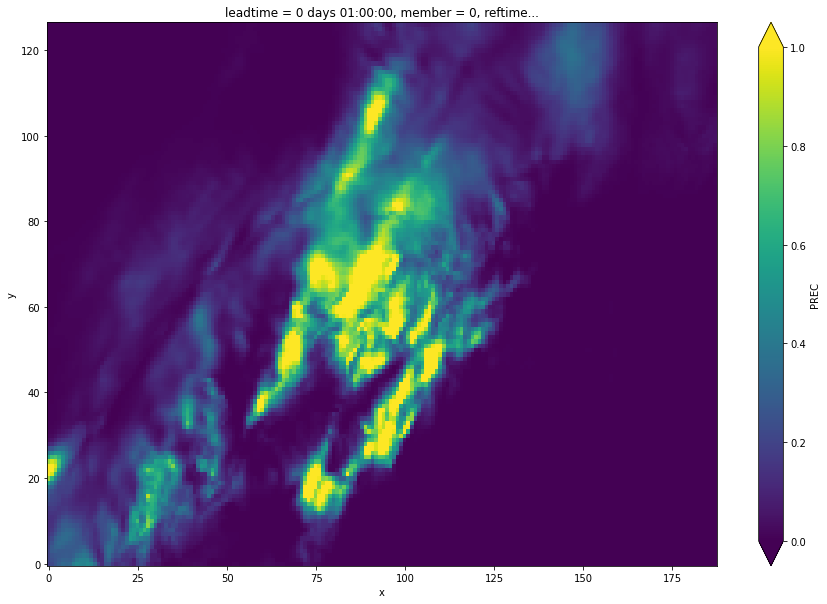

In [7]:
plt.figure(figsize=(15,10))
cosmo.PREC.isel(leadtime=1, member=0, reftime=0).plot.pcolormesh("x", "y", cmap='viridis', vmin=0, vmax=1)
plt.show()

### Reproject in Swiss coordinates

In [8]:
src_proj = pyproj.Proj("EPSG:4326")
dst_proj = pyproj.Proj("EPSG:21781")

src_x = cosmo.lon.values
src_y = cosmo.lat.values
dst_x, dst_y = pyproj.transform(src_proj, dst_proj, src_x, src_y, always_xy=True)

cosmo = cosmo.assign_coords({"chx": (("y", "x"), dst_x) , "chy": (("y", "x"), dst_y)})
cosmo

/Users/alexandrabutoi/Documents/GitHub/Realistic-looking-rainfall-forecasts/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  


<xarray.Dataset>
Dimensions:   (leadtime: 121, member: 21, reftime: 62, x: 188, y: 127)
Coordinates:
    lat       (y, x) float32 dask.array<chunksize=(127, 188), meta=np.ndarray>
  * leadtime  (leadtime) timedelta64[ns] 00:00:00 01:00:00 ... 5 days 00:00:00
    lon       (y, x) float32 dask.array<chunksize=(127, 188), meta=np.ndarray>
  * member    (member) int32 0 1 2 3 4 5 6 7 8 9 ... 12 13 14 15 16 17 18 19 20
  * reftime   (reftime) datetime64[ns] 2018-05-01 ... 2018-05-31T12:00:00
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 180 181 182 183 184 185 186 187
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 119 120 121 122 123 124 125 126
    chx       (y, x) float64 4.5e+05 4.522e+05 4.544e+05 ... 8.554e+05 8.577e+05
    chy       (y, x) float64 3.944e+04 3.951e+04 3.958e+04 ... 3.33e+05 3.33e+05
Data variables:
    PREC      (reftime, leadtime, member, y, x) float32 dask.array<chunksize=(1, 41, 21, 127, 188), meta=np.ndarray>

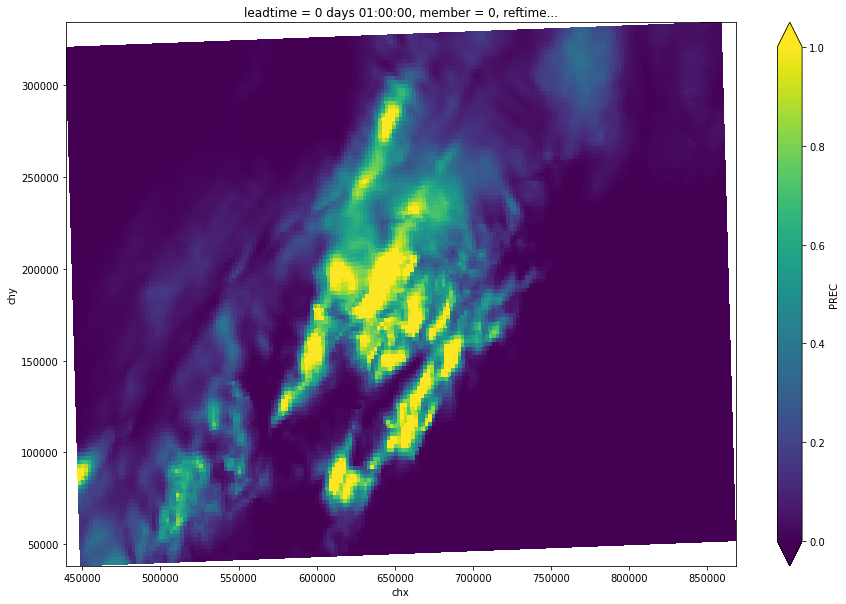

In [9]:
plt.figure(figsize=(15,10))
cosmo.PREC.isel(leadtime=1, member=0, reftime=0).plot.pcolormesh("chx", "chy", cmap='viridis', vmin=0, vmax=1)
plt.show()

#### Analysis

In [10]:
cosmo.PREC.isel(leadtime=1, member=0, reftime=1).values # 2018-05-01T01:00:00

array([[0.02672195, 0.0332675 , 0.03746748, ..., 0.        , 0.        ,
        0.        ],
       [0.02465391, 0.03008938, 0.03343773, ..., 0.        , 0.        ,
        0.        ],
       [0.02243328, 0.02795124, 0.03022146, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [11]:
cosmo.PREC.isel(leadtime=0, member=0, reftime=0).values # no values before 2018-05-01T00:00:00

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [12]:
cosmo.PREC.reftime.values[0], cosmo.PREC.reftime.values[-1]

(numpy.datetime64('2018-05-01T00:00:00.000000000'),
 numpy.datetime64('2018-05-31T12:00:00.000000000'))

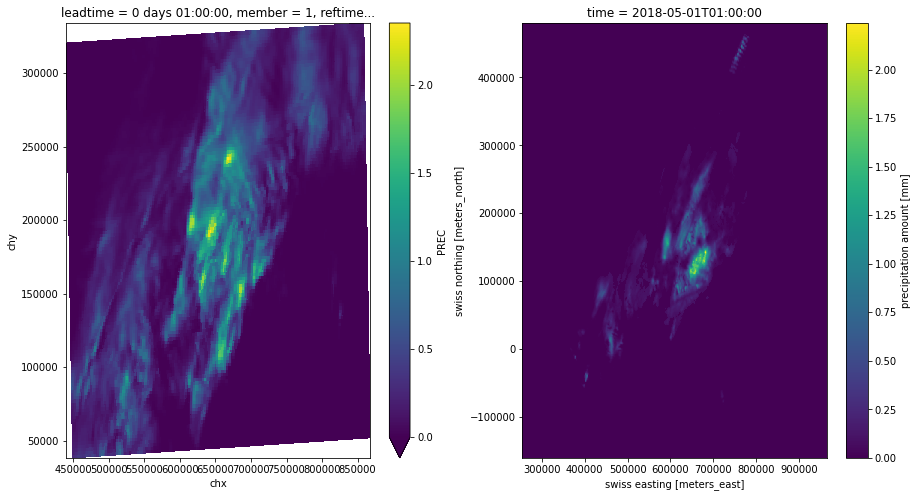

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(15,8))
cosmo.PREC.isel(leadtime=1, member=1, reftime=0).plot.pcolormesh("chx", "chy", ax=axes[0], cmap='viridis', vmin=0)
ds.RR.isel(time=0).plot.pcolormesh("chx", "chy", ax=axes[1])

In [14]:
# predictions and observations for the hour before
print(cosmo.PREC.isel(leadtime=1, member=1, reftime=0).reftime + cosmo.PREC.isel(leadtime=1, member=1, reftime=0).leadtime)
print(ds.RR.isel(time=0).time)

<xarray.DataArray ()>
array('2018-05-01T01:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    leadtime  timedelta64[ns] 01:00:00
    member    int32 1
    reftime   datetime64[ns] 2018-05-01
<xarray.DataArray 'time' ()>
array('2018-05-01T01:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2018-05-01T01:00:00
Attributes:
    long_name:  time
    axis:       T


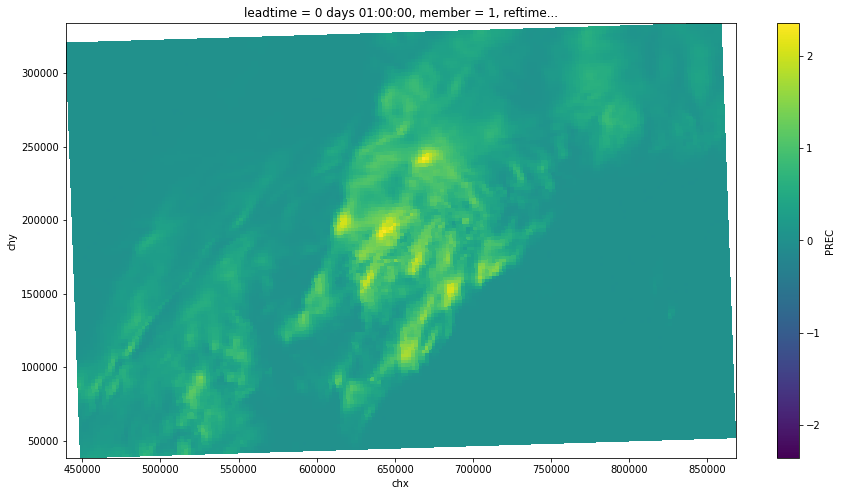

In [35]:
fig, axes = plt.subplots(ncols=1, figsize=(15,8))
cosmo.PREC.isel(leadtime=1, member=1, reftime=0, x=).plot.pcolormesh("chx", "chy", cmap='viridis')
plt.show()

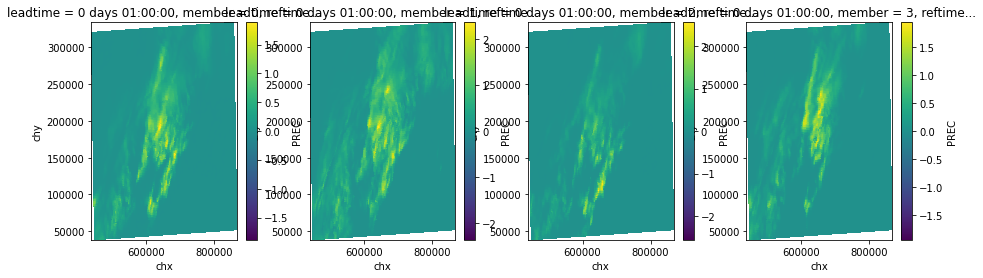

In [34]:
# show multiple members of the ensemble
fig, axes = plt.subplots(ncols=4, figsize=(15,4))
for i in range(4):
    cosmo.PREC.isel(leadtime=1, member=i, reftime=0).plot.pcolormesh("chx", "chy", ax=axes[i], cmap='viridis')

In [17]:
cosmo.PREC.isel(leadtime=1, member=1, reftime=0).values

array([[0.2622509 , 0.29839706, 0.3298893 , ..., 0.        , 0.        ,
        0.        ],
       [0.21137619, 0.23625374, 0.26683044, ..., 0.        , 0.        ,
        0.        ],
       [0.19594383, 0.20388985, 0.21299362, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0064373 , 0.00613594, 0.00534439, ..., 0.12298775, 0.12989044,
        0.14653015],
       [0.00673866, 0.00661659, 0.00594521, ..., 0.13867569, 0.13545036,
        0.147192  ],
       [0.00673866, 0.00673866, 0.0063076 , ..., 0.17636871, 0.16921043,
        0.16905403]], dtype=float32)

In [18]:
cosmo.PREC.isel(leadtime=0, member=1, reftime=0).reftime.values # check date format

numpy.datetime64('2018-05-01T00:00:00.000000000')

In [19]:
cosmo.PREC.isel(leadtime=2, member=1, reftime=0).leadtime.values # check time format

numpy.timedelta64(7200000000000,'ns')

In [20]:
# COSMO-E has reftime at 00:00 and 12:00, CombiPrecip has every hour
cosmo.PREC.reftime.values.shape, cosmo.PREC.leadtime.values.shape, ds.RR.time.values.shape

((62,), (121,), (744,))

In [21]:
cosmo.PREC.leadtime.values  # hourly after reftime

array([              0,   3600000000000,   7200000000000,  10800000000000,
        14400000000000,  18000000000000,  21600000000000,  25200000000000,
        28800000000000,  32400000000000,  36000000000000,  39600000000000,
        43200000000000,  46800000000000,  50400000000000,  54000000000000,
        57600000000000,  61200000000000,  64800000000000,  68400000000000,
        72000000000000,  75600000000000,  79200000000000,  82800000000000,
        86400000000000,  90000000000000,  93600000000000,  97200000000000,
       100800000000000, 104400000000000, 108000000000000, 111600000000000,
       115200000000000, 118800000000000, 122400000000000, 126000000000000,
       129600000000000, 133200000000000, 136800000000000, 140400000000000,
       144000000000000, 147600000000000, 151200000000000, 154800000000000,
       158400000000000, 162000000000000, 165600000000000, 169200000000000,
       172800000000000, 176400000000000, 180000000000000, 183600000000000,
       187200000000000, 1

In [22]:
cosmo.PREC.reftime[-2] + cosmo.PREC.leadtime # add reftime to leadtime

<xarray.DataArray (leadtime: 121)>
array(['2018-05-31T00:00:00.000000000', '2018-05-31T01:00:00.000000000',
       '2018-05-31T02:00:00.000000000', '2018-05-31T03:00:00.000000000',
       '2018-05-31T04:00:00.000000000', '2018-05-31T05:00:00.000000000',
       '2018-05-31T06:00:00.000000000', '2018-05-31T07:00:00.000000000',
       '2018-05-31T08:00:00.000000000', '2018-05-31T09:00:00.000000000',
       '2018-05-31T10:00:00.000000000', '2018-05-31T11:00:00.000000000',
       '2018-05-31T12:00:00.000000000', '2018-05-31T13:00:00.000000000',
       '2018-05-31T14:00:00.000000000', '2018-05-31T15:00:00.000000000',
       '2018-05-31T16:00:00.000000000', '2018-05-31T17:00:00.000000000',
       '2018-05-31T18:00:00.000000000', '2018-05-31T19:00:00.000000000',
       '2018-05-31T20:00:00.000000000', '2018-05-31T21:00:00.000000000',
       '2018-05-31T22:00:00.000000000', '2018-05-31T23:00:00.000000000',
       '2018-06-01T00:00:00.000000000', '2018-06-01T01:00:00.000000000',
       '2018-06-01T02:00:00.000000000', '2018-06-01T03:00:00.000000000',
       '2018-06-01T04:00:00.000000000', '2018-06-01T05:00:00.000000000',
       '2018-06-01T06:00:00.000000000', '2018-06-01T07:00:00.000000000',
       '2018-06-01T08:00:00.000000000', '2018-06-01T09:00:00.000000000',
       '2018-06-01T10:00:00.000000000', '2018-06-01T11:00:00.000000000',
       '2018-06-01T12:00:00.000000000', '2018-06-01T13:00:00.000000000',
       '2018-06-01T14:00:00.000000000', '2018-06-01T15:00:00.000000000',
...
       '2018-06-03T10:00:00.000000000', '2018-06-03T11:00:00.000000000',
       '2018-06-03T12:00:00.000000000', '2018-06-03T13:00:00.000000000',
       '2018-06-03T14:00:00.000000000', '2018-06-03T15:00:00.000000000',
       '2018-06-03T16:00:00.000000000', '2018-06-03T17:00:00.000000000',
       '2018-06-03T18:00:00.000000000', '2018-06-03T19:00:00.000000000',
       '2018-06-03T20:00:00.000000000', '2018-06-03T21:00:00.000000000',
       '2018-06-03T22:00:00.000000000', '2018-06-03T23:00:00.000000000',
       '2018-06-04T00:00:00.000000000', '2018-06-04T01:00:00.000000000',
       '2018-06-04T02:00:00.000000000', '2018-06-04T03:00:00.000000000',
       '2018-06-04T04:00:00.000000000', '2018-06-04T05:00:00.000000000',
       '2018-06-04T06:00:00.000000000', '2018-06-04T07:00:00.000000000',
       '2018-06-04T08:00:00.000000000', '2018-06-04T09:00:00.000000000',
       '2018-06-04T10:00:00.000000000', '2018-06-04T11:00:00.000000000',
       '2018-06-04T12:00:00.000000000', '2018-06-04T13:00:00.000000000',
       '2018-06-04T14:00:00.000000000', '2018-06-04T15:00:00.000000000',
       '2018-06-04T16:00:00.000000000', '2018-06-04T17:00:00.000000000',
       '2018-06-04T18:00:00.000000000', '2018-06-04T19:00:00.000000000',
       '2018-06-04T20:00:00.000000000', '2018-06-04T21:00:00.000000000',
       '2018-06-04T22:00:00.000000000', '2018-06-04T23:00:00.000000000',
       '2018-06-05T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    reftime   datetime64[ns] 2018-05-31
  * leadtime  (leadtime) timedelta64[ns] 00:00:00 01:00:00 ... 5 days 00:00:00

### Coordinates

In [23]:
cosmo.PREC.x.values.shape, cosmo.PREC.y.values.shape

((188,), (127,))

In [24]:
ds.RR.chx.values.shape, ds.RR.chy.values.shape

((710,), (640,))

In [25]:
cosmo.PREC.y.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126])

In [26]:
cosmo.PREC.chx.values

array([[449974.33803416, 452205.5472066 , 454433.33648937, ...,
        862338.79218558, 864567.74346389, 866796.65658073],
       [449901.25697796, 452132.44333542, 454360.25831394, ...,
        862266.27839465, 864495.25685705, 866724.1605387 ],
       [449828.15581523, 452059.36630064, 454287.1860673 , ...,
        862193.76743299, 864422.73599656, 866651.66646537],
       ...,
       [440914.90550943, 443146.38623578, 445374.47950375, ...,
        853349.99827545, 855579.35608519, 857808.80426424],
       [440841.83353431, 443073.33691843, 445301.40691206, ...,
        853277.4351176 , 855506.86851493, 857736.32124886],
       [440768.73307178, 443000.23553344, 445228.32858217, ...,
        853204.90475971, 855434.34188108, 857663.79834433]])

In [27]:
ds.RR.isel(time=0).values.shape

(640, 710)

In [28]:
ds.RR.chx.values

array([255500., 256500., 257500., 258500., 259500., 260500., 261500.,
       262500., 263500., 264500., 265500., 266500., 267500., 268500.,
       269500., 270500., 271500., 272500., 273500., 274500., 275500.,
       276500., 277500., 278500., 279500., 280500., 281500., 282500.,
       283500., 284500., 285500., 286500., 287500., 288500., 289500.,
       290500., 291500., 292500., 293500., 294500., 295500., 296500.,
       297500., 298500., 299500., 300500., 301500., 302500., 303500.,
       304500., 305500., 306500., 307500., 308500., 309500., 310500.,
       311500., 312500., 313500., 314500., 315500., 316500., 317500.,
       318500., 319500., 320500., 321500., 322500., 323500., 324500.,
       325500., 326500., 327500., 328500., 329500., 330500., 331500.,
       332500., 333500., 334500., 335500., 336500., 337500., 338500.,
       339500., 340500., 341500., 342500., 343500., 344500., 345500.,
       346500., 347500., 348500., 349500., 350500., 351500., 352500.,
       353500., 3545

In [29]:
ds.RR.chy.values

array([-159500., -158500., -157500., -156500., -155500., -154500.,
       -153500., -152500., -151500., -150500., -149500., -148500.,
       -147500., -146500., -145500., -144500., -143500., -142500.,
       -141500., -140500., -139500., -138500., -137500., -136500.,
       -135500., -134500., -133500., -132500., -131500., -130500.,
       -129500., -128500., -127500., -126500., -125500., -124500.,
       -123500., -122500., -121500., -120500., -119500., -118500.,
       -117500., -116500., -115500., -114500., -113500., -112500.,
       -111500., -110500., -109500., -108500., -107500., -106500.,
       -105500., -104500., -103500., -102500., -101500., -100500.,
        -99500.,  -98500.,  -97500.,  -96500.,  -95500.,  -94500.,
        -93500.,  -92500.,  -91500.,  -90500.,  -89500.,  -88500.,
        -87500.,  -86500.,  -85500.,  -84500.,  -83500.,  -82500.,
        -81500.,  -80500.,  -79500.,  -78500.,  -77500.,  -76500.,
        -75500.,  -74500.,  -73500.,  -72500.,  -71500.,  -705

In [112]:
ds.RR.isel(time=0).chy.values

array([-159500., -158500., -157500., -156500., -155500., -154500.,
       -153500., -152500., -151500., -150500., -149500., -148500.,
       -147500., -146500., -145500., -144500., -143500., -142500.,
       -141500., -140500., -139500., -138500., -137500., -136500.,
       -135500., -134500., -133500., -132500., -131500., -130500.,
       -129500., -128500., -127500., -126500., -125500., -124500.,
       -123500., -122500., -121500., -120500., -119500., -118500.,
       -117500., -116500., -115500., -114500., -113500., -112500.,
       -111500., -110500., -109500., -108500., -107500., -106500.,
       -105500., -104500., -103500., -102500., -101500., -100500.,
        -99500.,  -98500.,  -97500.,  -96500.,  -95500.,  -94500.,
        -93500.,  -92500.,  -91500.,  -90500.,  -89500.,  -88500.,
        -87500.,  -86500.,  -85500.,  -84500.,  -83500.,  -82500.,
        -81500.,  -80500.,  -79500.,  -78500.,  -77500.,  -76500.,
        -75500.,  -74500.,  -73500.,  -72500.,  -71500.,  -705

In [134]:
cosmo.PREC.lat.values

array([[45.490215, 45.491356, 45.492485, ..., 45.57714 , 45.576935,
        45.576717],
       [45.51018 , 45.511322, 45.512455, ..., 45.59714 , 45.59693 ,
        45.596718],
       [45.530148, 45.531292, 45.53242 , ..., 45.617138, 45.616932,
        45.616714],
       ...,
       [47.965973, 47.967167, 47.96835 , ..., 48.057007, 48.05679 ,
        48.056564],
       [47.985935, 47.987133, 47.988316, ..., 48.077003, 48.076786,
        48.07656 ],
       [48.0059  , 48.007095, 48.00828 , ..., 48.097004, 48.096786,
        48.09656 ]], dtype=float32)

In [52]:
cosmo.PREC.chx.values[1:10,1:10]

array([[452132.44333542, 454360.25831394, 456591.4841978 ,
        458819.26549517, 461047.10542109, 463278.28346799,
        465506.09342414, 467733.88934357, 469965.10864893],
       [452059.36630064, 454287.1860673 , 456518.39837791,
        458746.18465439, 460974.00216719, 463205.2032514 ,
        465433.02777115, 467660.84736592, 469892.033469  ],
       [451986.29570601, 454214.10278721, 456445.31816956,
        458673.12856957, 460900.92296019, 463132.1368759 ,
        465359.93814463, 467587.77167158, 469818.9794343 ],
       [451913.20466205, 454141.02562983, 456372.22633291,
        458600.05033439, 460827.85826786, 463059.0844328 ,
        465286.89911419, 467514.70877202, 469745.92859667],
       [451840.1407841 , 454067.93769436, 456299.1775087 ,
        458526.98728789, 460754.80818176, 462986.00880758,
        465213.83631956, 467441.62155321, 469672.85285768],
       [451767.04642962, 453994.85607562, 456226.08009046,
        458453.89250845, 460681.73560065, 462912.94

##### How to collocate the COSMO coordinates with CombiPrecip coordinates????

#### kNN

In [104]:
point = cosmo.PREC.isel(leadtime=1, member=1, reftime=0, x=0, y=0)
chx, chy = point['chx'], point['chy']
chx.values, chy.values

(array(449974.33803416), array(39435.62025801))

In [105]:
real_point = ds.RR.isel(time=0).sel(chx=chx, chy=chy, method='nearest')

In [106]:
real_point['chx'].values, real_point['chy'].values

(array(449500.), array(39500.))

In [108]:
point_1 = cosmo.PREC.isel(leadtime=1, member=1, reftime=0, x=-1, y=-1)
chx, chy = point_1['chx'], point_1['chy']
chx.values, chy.values

(array(857663.79834433), array(333047.83950682))

In [109]:
real_point_1 = ds.RR.isel(time=0).sel(chx=chx, chy=chy, method='nearest')
real_point_1['chx'].values, real_point_1['chy'].values

(array(857500.), array(333500.))

In [113]:
real_point_1.values

array(0.)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15,8))
cosmo.PREC.isel(leadtime=1, member=1, reftime=0).plot.pcolormesh("chx", "chy", ax=axes[0], cmap='viridis', vmin=0)
ds.RR.isel(time=0).plot.pcolormesh("chx", "chy", ax=axes[1])

________________________________________________

In [144]:
coords = np.column_stack((ds.RR.chx.values.ravel(), ds.RR.chy.values.ravel()))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 710 and the array at index 1 has size 640

In [138]:
tree = cKDTree(coords)

In [143]:
point = cosmo.PREC.isel(leadtime=1, member=1, reftime=0, x=0, y=0)
chx, chy = point['chx'], point['chy']
new_coords = chx.values, chy.values

In [140]:
new_index = tree.query(new_coords)

In [141]:
new_index = np.unravel_index(new_index, self.shape)

(451648.8375939878, 454399)

### Verification

#### Log-spectral distance (LSD)

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([0.       , 0.0078125, 0.015625 , 0.0234375, 0.03125  , 0.0390625,
        0.046875 , 0.0546875, 0.0625   , 0.0703125, 0.078125 , 0.0859375,
        0.09375  , 0.1015625, 0.109375 , 0.1171875, 0.125    , 0.1328125,
        0.140625 , 0.1484375, 0.15625  , 0.1640625,

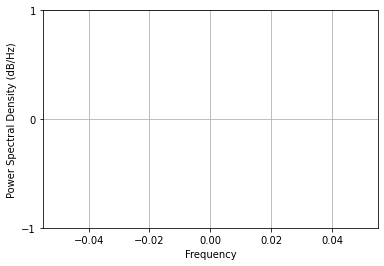

In [32]:
plt.psd(cosmo.PREC.isel(leadtime=0, member=1, reftime=0).values)

### Ranked probability Score

### Brier Score